# Noise Model Test Bank (only on QLM)

The module **model_noise** from **qpu** package allows to creation of a noise model for simulation. The following noisy channels can be added to the noisy model easily.

1. Depolarizing channel.
2. Amplitude Damping.
3. Dephasing (only if there is Amplitude Damping).
4. Measurement Channel.

To configure a noisy model an input dictionary with the following format should be provided:

{

    'qpu': "noisy",# ideal or noisy
    
    't_gate_1qb': 35,# ns
    
    't_gate_2qbs': 660,# ns
    
    't_readout': 4000, # ns
    
    'depol_channel': {
        'active': True, # True or False
        'error_gate_1qb': 1.0e-4,# float
        'error_gate_2qbs': 1.0e-3 # float
    },
    
    'idle': {
        'amplitude_damping': True, # True or False
        'dephasing_channel': True, # True or False
        't1': 0.2e6, #ns
        't2': 0.1e6 #ns
    },
    
    'meas': {
        'active': True, # True or False
        'readout_error': 1.370e-2# float
    }
}

The implemented noise model in **model_noise** module has the following assumptions:

1. The time for 1-qubit gates will be the same for all the possible 1-qubit gates: **t_gate_1qb**. The hardware model sets all the 1-qubit gates (used or not) to this value.
2. The time for 2-qubit gates will be the same for all the possible 2-qubit gates: **t_gate_2qbs**. The hardware model sets all the 2-qubit gates (used or not) to this value.
3. Times for 3-qubit gates (or more) **WON'T BE FIXED**. A rewriter plugin is recommended to use (in the module a Toffoli rewritter is added to the final qpu).
4. Amplitude Damping channels and  Dephasing channels should be enabled under the *idle* key of the dictionary:
    * The Dephasing channel will be enabled only if the Amplitude Damping channel is enabled too. This is because $T_1$ and $T_2$ are needed for generating parameter $T_{\varphi}$ for Dephasing channel.
    * $T_{\varphi} = \frac{1}{\frac{1}{T_2} - \frac{1}{2 T_1}}$
6. Depolarizing channel should be enabled and configured under the *depol_channel* key:
    * In the *Depolarizing channel* each time an ideal gate is applied then the depolarizing channel is applied
    * The *Depolarizing channel* will be the same for the 1 and 2 qubit gates.
    * The error associated to all the 1-qubit gates will be the same: **error_gate_1qb**
    * The error associated to all the 2-qubit gates will be the same:: **error_gate_2qbs**
7. Only default gates in Qaptiva **DefaultHardwareModel** can be used. If *hw_model* is a **DefaultHardwareModel** object the default Qaptiva gates can be listed in the following dictionaries:
    * hw_model.gates_specification.quantum_channels: Gates and corresponding definitions. Gates can be of the following type: 
        * QuantumChannelKraus. Using *arity* attribute e can know if they are of 1, 2 or more qubits.
        * _ParametricChannel (paramétric gates of 1 qubit)
        * _CtrlParametricChannel (controlled parametric gates: 2 qubits)
    * hw_model.gates_specification.gate_times: dictionary with pair key (gate name) value (execution time of the gate)

### Toshiko

T1 = 50 # us
T2= 30 # us
F1 = 99.9 # %
F2 = 92 # %
F_ro = 90 # %

In [ ]:
import sys
sys.path.append("../")

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import qat.lang.AQASM as qlm
import json
%matplotlib inline

In [ ]:
from qat.qpus import LinAlg

In [ ]:
ideal_qpu = LinAlg()

## List of gates

In [ ]:
from qat.hardware import DefaultHardwareModel

In [ ]:
hw_md = DefaultHardwareModel()

In [ ]:
# Gates and asociated quantum channels
hw_md.gates_specification.quantum_channels

In [ ]:
# The Kraus operator is the ideal gate
hw_md.gates_specification.quantum_channels["H"].kraus_operators

In [ ]:
# time of the gates
hw_md.gates_specification.gate_times

## 1. Probability Loading problem

We are going to use the probability loading problem for playing with the noise models

In [ ]:
from load_probabilities import LoadProbabilityDensity

First the configuration dictionary for the class should be provided

In [ ]:
configuration = {
    "load_method": "multiplexor", 
    "number_of_qbits": 6,
}

## 2. Ideal Solution

To get the ideal solution the *get_qpu* function from  **PL.qpu.get_qpu** module can be used. In this case, the input should be one of the following strings:

* *qlmass_linalg*: to use the **LinAlg Quantum Learning Machine (QLM)** algebra simulator. In this case, the computation will be sent to the **QLM** by using the  Qaptiva QLM as a Service.
* *qlmass_mps*: to use **MPS QLM** simulator. In this case, the computation will be sent to the **QLM** by using the  Qaptiva QLM as a Service.
* *python*: to use the PyLinalg algebra simulator.
* *c*: to use the CLinalg alegbra simulator.
* *linalg*: to use the **LinAlg QLM**. In this case, the user should be inside a **EVIDEN QLM**
* *mps*: to use the **MPS QLM** simulator. In this case, the user should be inside a **EVIDEN QLM**

 


In [ ]:
from qpu.get_qpu import get_qpu

In [ ]:
qpu_ideal = get_qpu("linalg")
configuration.update({"qpu":qpu_ideal})

Now the class and their methods and attributes can be used straight forward.

In [ ]:
btc_pl_ideal = LoadProbabilityDensity(**configuration)
btc_pl_ideal.exe()

In [ ]:
ideal_solution = btc_pl_ideal.pdf

In [ ]:
ideal_solution

In [ ]:
btc_pl_ideal.result

In [ ]:
plt.plot(btc_pl_ideal.result["x"], btc_pl_ideal.result["Probability"], 'o')
plt.plot(btc_pl_ideal.x_, btc_pl_ideal.data, '-')

In [ ]:
c = btc_pl_ideal.circuit

In [ ]:
%qatdisplay c --depth


Additionally, the more general *select_qpu* function from **PL.qpu.select_qpu** module can be used. In this case, a complete python dictionary (shown in the following cells) should be used. 

The ideal qpu is provided in the *qpu_type* key of the dictionary and the value is the same that should be provided to the  *get_qpu* function from  **PL.qpu.get_qpu** .

In [ ]:
from qpu.select_qpu import select_qpu
from qpu.benchmark_utils import combination_for_list

In [ ]:
qpus = ["c", "python", "linalg", "mps", "qlmass_linalg", "qlmass_mps"]
# Configuration dictionary
conf_ideal = [{
    "qpu_type": [qpus[2]],
    "t_gate_1qb" : [None],
    "t_gate_2qbs" : [None],
    "t_readout": [None],
    "depol_channel" : [{
        "active": False,
        "error_gate_1qb" : None,
        "error_gate_2qbs" : None
    }],
    "idle" : [{
        "amplitude_damping": False,
        "dephasing_channel": False,
        "t1" : None,
        "t2" : None
    }],
    "meas": [{
        "active":False,
        "readout_error": None
    }]
}]

# We use the combination_for_list for getting the proper format for the dictionary
ideal_qpu_conf = combination_for_list(conf_ideal)[0]
print(ideal_qpu_conf)

In [ ]:
ideal_qpu_2 = select_qpu(ideal_qpu_conf)
configuration.update({"qpu":ideal_qpu_2})
btc_pl_ideal_2 = LoadProbabilityDensity(**configuration)
btc_pl_ideal_2.exe()
ideal_solution_2 = btc_pl_ideal_2.pdf

In [ ]:
ideal_solution_2["KS"], ideal_solution["KS"]

In [ ]:
ideal_solution_2["KL"], ideal_solution["KL"]

In [ ]:
#plt.bar(btc_pl_ideal_2.result["x"], btc_pl_ideal_2.result["Probability"])
plt.plot(btc_pl_ideal_2.result["x"], btc_pl_ideal_2.result["Probability"], 'o')
plt.plot(btc_pl_ideal_2.x_, btc_pl_ideal_2.data,'-', c="r")

#### Toffoli rewritter

The Noisy model, defined in the **qpu.model_noise**, uses a Toffoli re-writer for getting a final circuit composed only of 1 and 2-qubit gates. 

An ideal qpu that includes this Toffoli rewriter can be created using the *select_qpu* function by providing to the *qpu_type* key the string **ideal**.

The probability loading circuits only have 1 and 2-qubit gates.

In [ ]:
ideal_toffoli_rewritter = [{
    "qpu_type": ["ideal"],
    "t_gate_1qb" : [None],
    "t_gate_2qbs" : [None],
    "t_readout": [None],
    "depol_channel" : [{
        "active": False,
        "error_gate_1qb" : None,
        "error_gate_2qbs" : None
    }],
    "idle" : [{
        "amplitude_damping": False,
        "dephasing_channel": False,
        "t1" : None,
        "t2" : None
    }],
    "meas": [{
        "active":False,
        "readout_error": None
    }]
}]
conf_ideal_no_toffoli = combination_for_list(ideal_toffoli_rewritter)[0]
conf_ideal_no_toffoli

In [ ]:
ideal_qpu_toffoli_rew = select_qpu(conf_ideal_no_toffoli)

configuration.update({"qpu":ideal_qpu_toffoli_rew})
btc_pl_toffoli_ideal = LoadProbabilityDensity(**configuration)
btc_pl_toffoli_ideal.exe()
ideal_solution_toffoli = btc_pl_toffoli_ideal.pdf

In [ ]:
ideal_solution_2["KS"], ideal_solution["KS"], ideal_solution_toffoli["KS"]

In [ ]:
ideal_solution_2["KL"], ideal_solution["KL"], ideal_solution_toffoli["KL"]

## 3. Solution with Noisy hardware

For simulating the noisy hardware we need to configure the noisy hardware model and create a noisy QPU. This can be done with the *create_qpu* from **qpu.model_noise**. However, the wrapper function *select_qpu* from **qpu.select_qpu** module is recommended for these tasks.

For selecting noisy hardware models the *qpu_type* key of the input configuration dictionary should have the string *noisy*.

The rest of the keys of the input dictionary can be used for activating or deactivating, and configuring, the different quantum channels implemented in our noise model.

### 3.1 Depolarizing channel

For selecting only a depolarizing channel model in our noisy model the *depol_channel* key of the input configuration dictionary should be configured. The value of this key is a Python dictionary with the following keys:

* *active*: the corresponding value is a boolean for activating (True) or deactivating (False) the depolarizing channel.
* *error_gate_1qb*: the corresponding value is a float value that represents the error of all the 1-qubit gates.
* *error_gate_2qbs*: the corresponding value is a float value that represents the error of all the 2-qubit gates.

### Toshiko

T1 = 50 # us
T2= 30 # us
F1 = 99.9 # %
F2 = 92 # %
F_ro = 90 # %

In [ ]:
# Configuring test for Deploarizing channel
conf_noise = [{
    "qpu_type": ["noisy"],
    "t_gate_1qb" : [35],
    "t_gate_2qbs" : [660],
    "t_readout": [0],
    "depol_channel" : [
        {
            "active": True,
            "error_gate_1qb" : 1.0e-9,
            "error_gate_2qbs" : 1.0e-8
        },
        {
            "active": True,
            "error_gate_1qb" : 1.0e-8,
            "error_gate_2qbs" : 1.0e-7
        },       
        {
            "active": True,
            "error_gate_1qb" : 1.0e-7,
            "error_gate_2qbs" : 1.0e-6
        },               
        {
            "active": True,
            "error_gate_1qb" : 1.0e-6,
            "error_gate_2qbs" : 1.0e-5
        },   
        {
            "active": True,
            "error_gate_1qb" : 1.0e-5,
            "error_gate_2qbs" : 1.0e-4
        },  
        {
            "active": True,
            "error_gate_1qb" : 2.27e-4, # brisbane
            "error_gate_2qbs" : 7.741e-3 # brisbane
        },        
        {
            "active": True,
            "error_gate_1qb" : 0.001, # Toshiko
            "error_gate_2qbs" : 0.08 # Toshiko
        },            
    ],
    "idle" : [{
        "amplitude_damping": False,
        "dephasing_channel": False,
        "t1" : None,
        "t2" : None
    }],
    "meas": [{
        "active":False,
        "readout_error": None
    }]
}]
# Now we have a list with different dictionaries
noisy_conf_list = combination_for_list(conf_noise)

In [ ]:
# Now we are going to solve the circuit with all the different depolarising channel configurations
a_depol = []

error1 = []
kl = []
ks = []
list_th = []
for hw_m in noisy_conf_list:
    my_noisy_qpu = select_qpu(hw_m)
    print(hw_m)
    configuration.update({"qpu":my_noisy_qpu})
    error1.append(hw_m["depol_channel"]["error_gate_1qb"])
    btc_pl_noisy = LoadProbabilityDensity(**configuration)
    btc_pl_noisy.exe()
    kl.append(btc_pl_noisy.pdf["KL"])
    ks.append(btc_pl_noisy.pdf["KS"])
    list_th.append(btc_pl_noisy.kl_pdf)
kl = pd.concat(kl)
ks = pd.concat(ks)    

In [ ]:
plt.plot(error1, np.abs(kl - ideal_solution_2["KL"]), '-o')
plt.plot(error1, np.abs(ks - ideal_solution_2["KS"]), '-o')
#plt.axhline(medida_no_toffoli, c='r')
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Error 1 qubit gate")
plt.ylabel(r"Ideal - Noisy ")
plt.title("Only depolarizing channel. No iddle qubit")
plt.legend(["KL", "KS"])

In [ ]:
plt.plot(error1, kl, '-o')
plt.axhline(ideal_solution_2["KL"].iloc[0], c='r')
plt.plot(error1, ks, '-o')
plt.axhline(ideal_solution_2["KS"].iloc[0], c='r')
#plt.yscale("log")
plt.xscale("log")
plt.xlabel("Error 1 qubit gate")
plt.ylabel(r"$\hat{a}$")
plt.title("Only depolarizing channel. No iddle qubit")

In [ ]:
index = 5
print(error1[index])
plt.plot(list_th[index]["x"], list_th[index]["Probability"], 'o')
plt.plot(list_th[index]["x"], list_th[index]["p_th"], '-')

Behaviour of the PL metrics (**KL** and **KS**) versus the error 1 qubit gate when only depolarizing channel is activated.


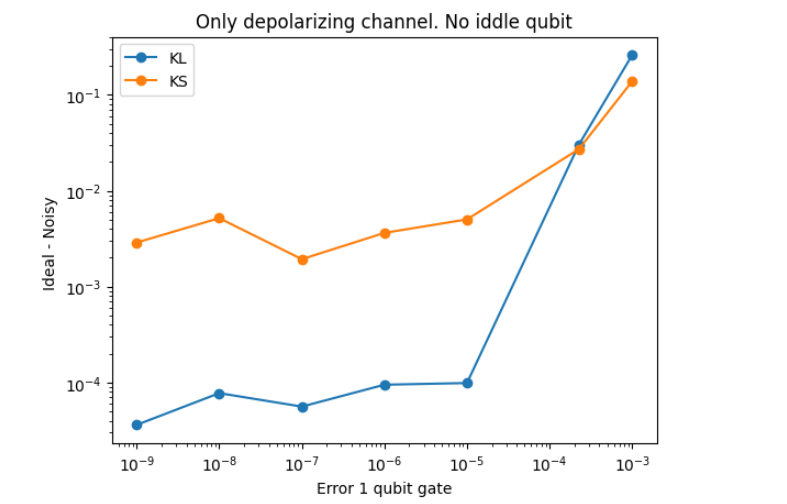

### 3.2 Amplitude Damping Channel (No Dephasing)


For selecting an Amplitude Damping Channel the *idle* key of the input configuration dictionary should be configured. The value of this key is a Python dictionary with the following keys:


* *amplitude_damping*: the corresponding value is a boolean for activating (True) or deactivating (False) the Amplitude Damping Channel 
* *t1*: T1 time in nanosecods.
* *dephasing_channel*: the boolean key that should be set to False (only if Amplitude Damping Channel is required)
* *t2*: T2 time in nanoseconds. Only valid if the *dephasing_channel* is set to True.


### Toshiko

T1 = 50 # us
T2= 30 # us
F1 = 99.9 # %
F2 = 92 # %
F_ro = 90 # %

In [ ]:
conf_noise = [{
    "qpu_type": ["noisy"],
    "t_gate_1qb" : [35],
    "t_gate_2qbs" : [660],
    "t_readout": [0],
    "depol_channel" : [
        {
            "active": False,
            "error_gate_1qb" : None,
            "error_gate_2qbs" : None
        }          
    ],
    "idle" : [
        {
            "amplitude_damping": True,
            "dephasing_channel": False,
            "t1" : 1000e6,
            "t2" : None
        },
        {
            "amplitude_damping": True,
            "dephasing_channel": False,
            "t1" : 100e6,
            "t2" : None
        },        
        {
            "amplitude_damping": True,
            "dephasing_channel": False,
            "t1" : 10e6,
            "t2" : None
        },     
        {
            "amplitude_damping": True,
            "dephasing_channel": False,
            "t1" : 1e6,
            "t2" : None
        },  
        {
            "amplitude_damping": True,
            "dephasing_channel": False,
            "t1" : 0.231e6, # brisbane
            "t2" : None 
        },       
        {
            "amplitude_damping": True,
            "dephasing_channel": False,
            "t1" : 50e3, # Toshiko: 50 us
            "t2" : None 
        }        
    ],
    "meas": [{
        "active":False,
        "readout_error": None
    }]
}]
noisy_conf_list = combination_for_list(conf_noise)

In [ ]:
kl = []
ks = []
list_th = []

error1 = []
for hw_m in noisy_conf_list:
    my_noisy_qpu = select_qpu(hw_m)
    print(hw_m)
    error1.append(hw_m["idle"]["t1"])
    configuration.update({"qpu":my_noisy_qpu})
    btc_pl_noisy = LoadProbabilityDensity(**configuration)
    btc_pl_noisy.exe()
    kl.append(btc_pl_noisy.pdf["KL"])
    ks.append(btc_pl_noisy.pdf["KS"])
    list_th.append(btc_pl_noisy.kl_pdf)    
kl = pd.concat(kl)
ks = pd.concat(ks)    

In [ ]:
%matplotlib inline

plt.plot(error1, np.abs(kl - ideal_solution_2["KL"]), '-o')
plt.plot(error1, np.abs(ks - ideal_solution_2["KS"]), '-o')

#plt.axhline(medida_no_toffoli, c='r')
plt.yscale("log")
plt.xscale("log")
plt.xlabel("T1 (ns)")
plt.ylabel(r"Ideal - Noisy ")
plt.title("Only Amplitude Damping. Ideal Gates")
plt.legend(["KL", "KS"])

In [ ]:
plt.plot(error1, kl, '-o')
plt.plot(error1, ks, '-o')
plt.axhline(ideal_solution_2["KL"].iloc[0], c='b')
plt.axhline(ideal_solution_2["KS"].iloc[0], c='r')
plt.yscale("log")
plt.xscale("log")
plt.xlabel("T1 (ns)")
plt.ylabel(r"$\hat{a}$")
plt.title("Only Amplitude Damping. Ideal Gates")
plt.legend(["KL", "KS"])

In [ ]:
index = -1
print(error1[index])
plt.plot(list_th[index]["x"], list_th[index]["Probability"], 'o')
plt.plot(list_th[index]["x"], list_th[index]["p_th"], '-')



#### Behaviour of the metrics versus $T_1$ (only amplitude damping channel)


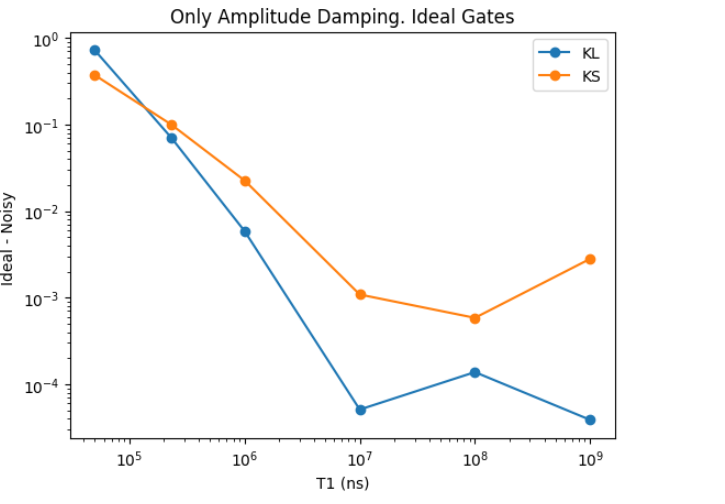

### 3.3 Amplitude Damping and Dephasing Channels

In addition to an Amplitude Damping a Dephasing Channel can be included in the noise hardware model. Again the *idle* key should be used. In this case the configuration is the following:



* *amplitude_damping*: the corresponding value is a boolean for activating (True) or deactivating (False) the Amplitude Damping Channel. It is mandatory have this cannel activated to activate a Dephasing Channel
* *t1*: T1 time in nanosecods (configuration for the Amplitude Damping channel)
* *dephasing_channel*: boolean key that should be set to True if  Dephasing Channel is required.
* *t2*: T2 time in nanoseconds. For configuring the Dephasing Channel. It is used in combination with T1 for computing $T_{\varphi}$ for Dephasing channel using the following parameter:
$$T_{\varphi} = \frac{1}{\frac{1}{T_2} - \frac{1}{2 T_1}}$$

### Toshiko

T1 = 50 # us
T2= 30 # us
F1 = 99.9 # %
F2 = 92 # %
F_ro = 90 # %

In [ ]:
conf_noise = [{
    "qpu_type": ["noisy"],# Palabara para generar qpus ruidosas
    "t_gate_1qb" : [35],
    "t_gate_2qbs" : [660],
    "t_readout": [0],
    "depol_channel" : [
        {
            "active": False,
            "error_gate_1qb" : None,
            "error_gate_2qbs" : None
        }          
    ],
    "idle" : [
        {
            "amplitude_damping": True,
            "dephasing_channel": True,
            "t1" : 1000e6,
            "t2" : 500e6
        },
        {
            "amplitude_damping": True,
            "dephasing_channel": True,
            "t1" : 100e6,
            "t2" : 50e6
        },        
        {
            "amplitude_damping": True,
            "dephasing_channel": True,
            "t1" : 10e6,
            "t2" : 5e6
        },     
        {
            "amplitude_damping": True,
            "dephasing_channel": True,
            "t1" : 1e6,
            "t2" : 0.5e6
        },  
        {
            "amplitude_damping": True,
            "dephasing_channel": True,
            "t1" : 0.231e6, # brisbane
            "t2" : 0.132e6 # brisbane
        }, 
        {
            "amplitude_damping": True,
            "dephasing_channel": True,
            "t1" : 50e3,  # Toshiko: 50 us
            "t2" : 30e3 # Toshiko: 30 us
        },              
    ],
    "meas": [{
        "active":False,
        "readout_error": None
    }]
}]
noisy_conf_list = combination_for_list(conf_noise)

In [ ]:
kl = []
ks = []
list_th = []

error1 = []
for hw_m in noisy_conf_list:
    my_noisy_qpu = select_qpu(hw_m)
    print(hw_m)
    t1 = hw_m["idle"]["t1"]
    t2 = hw_m["idle"]["t2"]
    t_varphi = 1.0 / ((1.0 / t2) - (1.0 / (2 * t1))) 
    error1.append(t_varphi)
    configuration.update({"qpu":my_noisy_qpu})
    btc_pl_noisy = LoadProbabilityDensity(**configuration)
    btc_pl_noisy.exe()
    kl.append(btc_pl_noisy.pdf["KL"])
    ks.append(btc_pl_noisy.pdf["KS"])
    list_th.append(btc_pl_noisy.kl_pdf)
kl = pd.concat(kl)
ks = pd.concat(ks)      

In [ ]:
plt.plot(error1, np.abs(kl - ideal_solution_2["KL"]), '-o')
plt.plot(error1, np.abs(ks - ideal_solution_2["KS"]), '-o')


plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$T_{\varphi}$")
plt.ylabel(r"Ideal - Noisy")
plt.title("Amplitude Damping and Dephasing channels. Ideal Gates")
plt.legend(["KL", "KS"])

In [ ]:
plt.plot(error1, kl, '-o')
plt.plot(error1, ks, '-o')
plt.axhline(ideal_solution_2["KL"].iloc[0], c='b')
plt.axhline(ideal_solution_2["KS"].iloc[0], c='r')

plt.yscale("log")
plt.xscale("log")
plt.xlabel("T1 (ns)")
plt.ylabel(r"Metrics")
plt.title("Amplitude Damping and Dephasing. Ideal Gates")
plt.legend(["KL", "KS"])

In [ ]:
index = -2
print(error1[index])
plt.plot(list_th[index]["x"], list_th[index]["Probability"], 'o')
plt.plot(list_th[index]["x"], list_th[index]["p_th"], '-')


#### Behaviour of the metrics versus $T_{\varphi}$ (amplitude damping and dephaising channel)

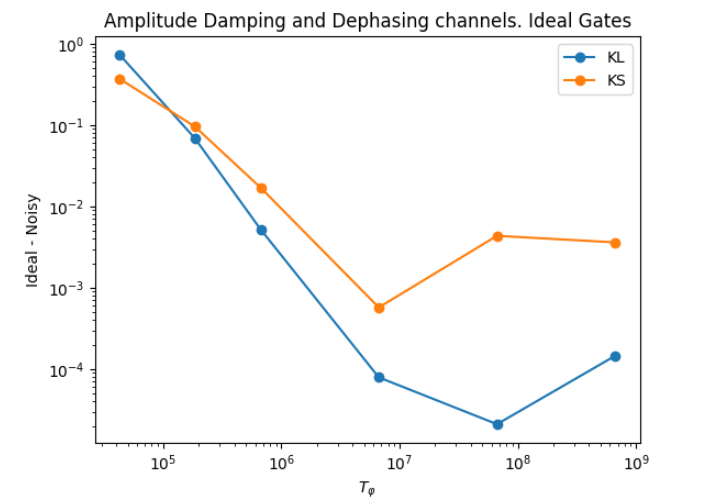

### 3.4 Redout error

For selecting a readout error the *meas* key should be used. The corresponding value is a Python dictionary with the following keys:

* active: the corresponding value is a boolean for activating (True) or deactivating (False) the readout error.
* readout_error: the corresponding value for the readout error

### Toshiko

T1 = 50 # us
T2= 30 # us
F1 = 99.9 # %
F2 = 92 # %
F_ro = 90 # %

In [ ]:
conf_noise = [{
    "qpu_type": ["noisy"],
    "t_gate_1qb" : [35],
    "t_gate_2qbs" : [660],
    "t_readout": [0],
    "depol_channel" : [
        {
            "active": False,
            "error_gate_1qb" : None,
            "error_gate_2qbs" : None
        }          
    ],
    "idle" : [
        {
            "amplitude_damping": False,
            "dephasing_channel": False,
            "t1" : None,
            "t2" : None
        }          
    ],
    "meas": [
        {
            "active":True,
            "readout_error": 1e-6
        },
        {
            "active":True,
            "readout_error": 1e-5
        },
        {
            "active":True,
            "readout_error": 1e-4
        },        
        {
            "active":True,
            "readout_error": 1e-3
        }, 
        {
            "active":True,
            "readout_error": 1.300e-2 # brisbane
        },
        {
            "active":True,
            "readout_error": 0.1 #Toshiko
        }        
    ]
}]
noisy_conf_list = combination_for_list(conf_noise)

In [ ]:
kl = []
ks = []
list_th = []

error1 = []
for hw_m in noisy_conf_list:
    my_noisy_qpu = select_qpu(hw_m)
    print(hw_m)
    error1.append(hw_m["meas"]["readout_error"])
    configuration.update({"qpu":my_noisy_qpu})
    btc_pl_noisy = LoadProbabilityDensity(**configuration)
    btc_pl_noisy.exe()
    kl.append(btc_pl_noisy.pdf["KL"])
    ks.append(btc_pl_noisy.pdf["KS"])
    list_th.append(btc_pl_noisy.kl_pdf)
kl = pd.concat(kl)
ks = pd.concat(ks)      

In [ ]:
plt.plot(error1, np.abs(kl - ideal_solution_2["KL"]), '-o')
plt.plot(error1, np.abs(ks - ideal_solution_2["KS"]), '-o')
#plt.axhline(medida_no_toffoli, c='r')
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Readout Error")
plt.ylabel(r"Ideal - Noisy")
plt.title("Only Readout Error.")

In [ ]:
plt.plot(error1, kl, '-o')
plt.plot(error1, ks, '-o')
plt.axhline(ideal_solution_2["KL"].iloc[0], c='b')
plt.axhline(ideal_solution_2["KS"].iloc[0], c='r')
#plt.yscale("log")
plt.xscale("log")
plt.ylabel(r"Metrics")
plt.xlabel(r"Readout")
plt.title("Only Readout Error.")

In [ ]:
index = -1
print(error1[index])
plt.plot(list_th[index]["x"], list_th[index]["Probability"], 'o')
plt.plot(list_th[index]["x"], list_th[index]["p_th"], '-')

#### Behaviour of the metrics versus Readout error


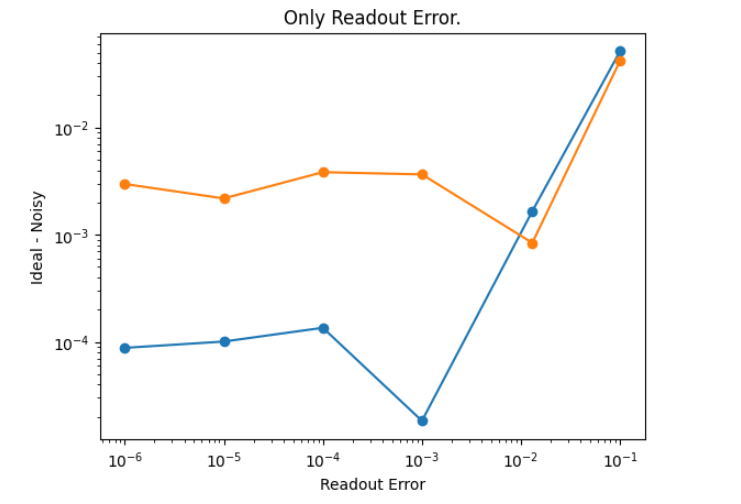